In [5]:
import numpy as np
from BPnumba.DABC import createDABC
from BPnumba.EDABC import createEDABC 
from BPnumba.GeneticOperators import InstancePob,CreatePoblation,CreateHeuristicPob,RRIS
import matplotlib.pyplot as plt
from BPmodule.BPGen import CreateData
from numba.typed import List as NumbaList
import random as rd
import numba as nb
import random

In [10]:
contenedor,datos = CreateData(algorithm=2,problem=3)

n=len(datos)
numItr = 500
num_pop= 50
poblation = CreateHeuristicPob(50,datos,contenedor)
n

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
abc = createDABC(num_pop,n)

In [ ]:
edabc = createEDABC(num_pop,n)

In [ ]:
ColonyWorker = InstancePob(NumbaList(poblation),datos,contenedor)

In [ ]:
edabc.Train(numItr,ColonyWorker,datos,contenedor)

In [ ]:
abc.Train(numItr,ColonyWorker,datos,contenedor)

In [ ]:
edabc.BestInd.fi,abc.BestInd.fi

(0.9598, 0.9899)

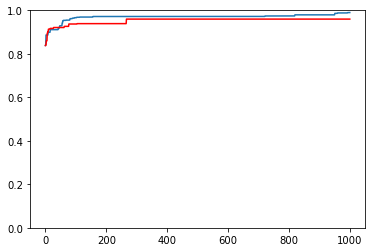

In [ ]:
plt.figure()
plt.plot(abc.bestfi)
plt.plot(edabc.bestfi,color='red')
plt.ylim(0,1)
plt.show()

In [ ]:
np.random.randint(0,3)

2